
# Creating a Full Sun Map with AIA and EUVI

With SDO/AIA and STEREO/A and STEREO/B, it is possible (for specific dates)
to combine combine three EUV images from these satellites to produce a nearly
full latitude / longitude map of the Sun.

You will need [reproject](https://reproject.readthedocs.io/en/stable/)_ v0.6 or higher installed.


In [ ]:
import sunpy.map
import astropy.units as u
from sunpy.net import Fido, attrs as a

unifresp = Fido.search(
    a.Time('2022-05-05 14:59:49', '2022-05-05 15:00:10'),
    a.Instrument("AIA"),    
    a.Wavelength(171 * u.angstrom)
    a.Sample(10 * u.minute)
)
 
print(unifresp)
AIA171 = Fido.fetch(unifresp)
EUI171 = Fido.fetch(unifresp)
StereoA171 = Fido.fetch(unifresp)

Results from 1 Provider:

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-05-05 14:59:49.000 2022-05-05 14:59:50.000    SDO ...    FULLDISK -0.00098




Files Downloaded: 100%|██████████| 1/1 [00:25<00:00, 25.32s/file]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import glob
import sunpy.map
import sunpy.sun
from sunpy.coordinates import get_body_heliographic_stonyhurst


c:\Users\Admin\anaconda3\envs\sunpy-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# The next two outputs was a test I was doing to see if I could only have the active parts of the Sun shown/outlined
import matplotlib.pyplot as plt
from scipy import ndimage

import sunpy.map
aiamap_mask = sunpy.map.Map(r"C:\Users\Admin\sunpy\data\aia.lev1.304A_2022_05_05T12_00_05.13Z.image_lev1.fits")
aiamap = sunpy.map.Map(r"C:\Users\Admin\sunpy\data\aia.lev1.304A_2022_05_05T12_00_05.13Z.image_lev1.fits")
mask = aiamap.data < aiamap.max() * 0.005

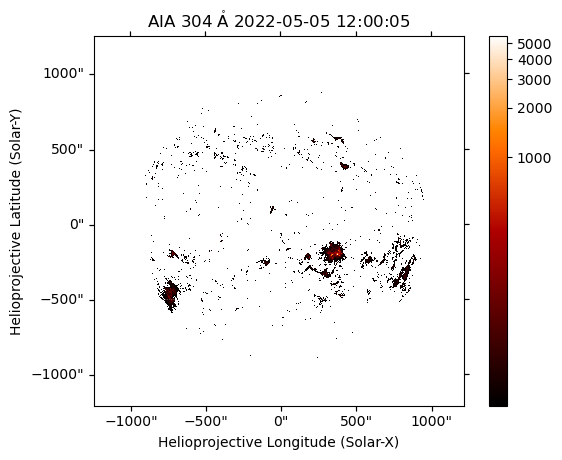

In [5]:
aiamap_mask.mask = mask

fig = plt.figure()
ax = fig.add_subplot(projection=aiamap_mask)
aiamap_mask.plot(axes=ax)
plt.colorbar()

plt.show()

First create a sunpy map for each of the files.



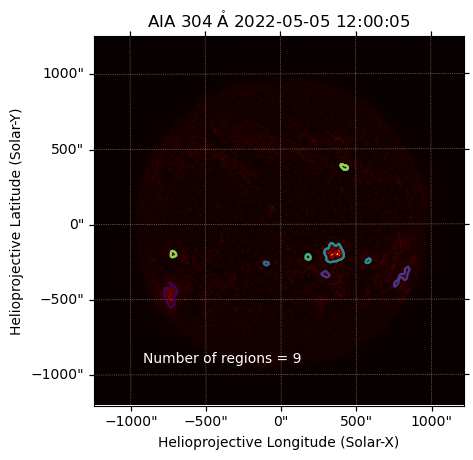

In [6]:
data2 = ndimage.gaussian_filter(aiamap.data * ~mask, 14)
data2[data2 < 35] = 0
aiamap2 = sunpy.map.Map(data2, aiamap.meta)
labels, n = ndimage.label(aiamap2.data)
fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax)
ax.contour(labels)
plt.figtext(0.3, 0.2, f'Number of regions = {n}', color='white')

plt.show()

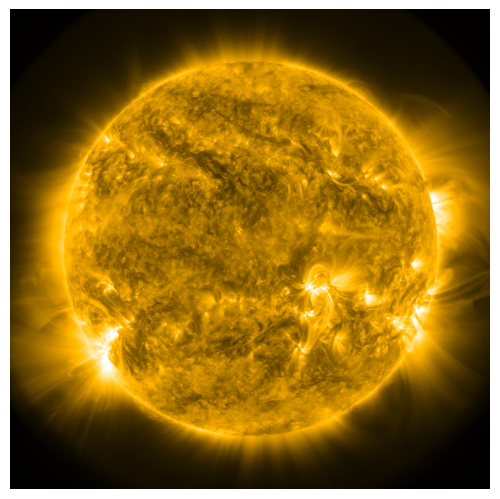

In [ ]:
AIA_171 = glob.glob(r"C:\Users\Admin\sunpy\data\aia.lev1.171A_2022_05_05T11_59_57.35Z.image_lev1.fits")
smap = sunpy.map.Map(sorted(AIA_171))
figure = plt.figure(frameon=False)
ax = plt.axes([0, 0, 1, 1])
# Disable the axis
ax.set_axis_off()

# Plot the map
norm = smap.plot_settings['norm']
norm.vmin, norm.vmax = np.percentile(smap.data, [1, 99.9])
ax.imshow(smap.data,
          norm=norm,
          cmap=smap.plot_settings['cmap'],
          origin="lower")

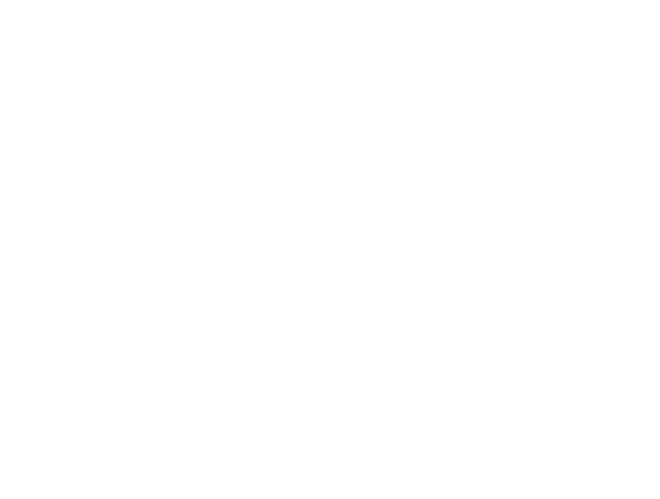

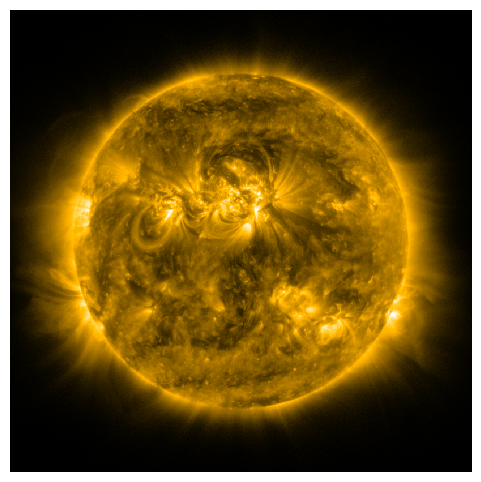

In [ ]:
EUI_171 = glob.glob(r"C:\Users\Admin\Downloads\solo_L2_eui-fsi174-image_20220505T120045268_V01.fits")
smap = sunpy.map.Map(sorted(EUI_171))
figure = plt.figure(frameon=False)
ax = plt.axes([0, 0, 1, 1])
# Disable the axis
ax.set_axis_off()

from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the region to zoom into
bottom_left = SkyCoord(-1750*u.arcsec, -1750*u.arcsec, frame=smap.coordinate_frame)
top_right   = SkyCoord( 1750*u.arcsec,  1750*u.arcsec, frame=smap.coordinate_frame)

zoom_map = smap.submap(bottom_left=bottom_left, top_right=top_right)


figure = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=zoom_map)
zoom_map.plot(axes=ax, annotate=False)
ax.set_axis_off()

plt.show()

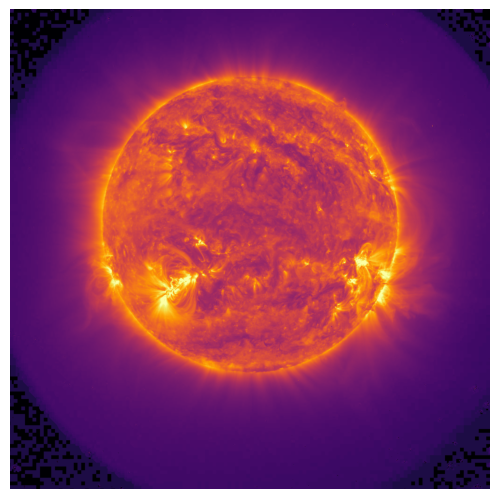

In [ ]:
    EUVI_171 = glob.glob(r"C:\Users\Admin\sunpy\data\20220505_120930_n4euA.fts")
    smap = sunpy.map.Map(sorted(EUVI_171))
    figure = plt.figure(frameon=False)
    ax = plt.axes([0, 0, 1, 1])
    # Disable the axis
    ax.set_axis_off()

    # Plot the map.
    norm = smap.plot_settings['norm']
    norm.vmin, norm.vmax = np.percentile(smap.data, [1, 99.9])
    ax.imshow(smap.data,
            norm=norm,
            cmap='inferno', # This can be changed for preference
            origin="lower")

In [3]:
AIA_304 = glob.glob(r"C:\Users\Admin\sunpy\data\aia.lev1.304A_2022_05_05T12_00_05.13Z.image_lev1.fits")
EUI_304 = glob.glob(r"C:\Users\Admin\sunpy\data\solo_L2_eui-fsi304-image_20220505T120015268_V01.fits")
EUVI_304 = glob.glob(r"C:\Users\Admin\sunpy\data\20220505_120545_n4euA.fts")

maps1 = sunpy.map.Map(sorted([AIA_304, EUVI_304, EUI_304]))

To reduce memory consumption we also downsample these maps before continuing,
you can disable this.



In [6]:
maps1 = [m.resample((1024, 1024)*u.pix) for m in maps1]

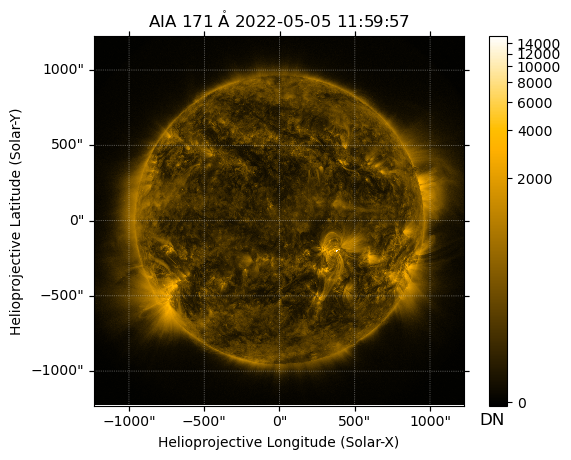

In [ ]:
maps1[2].peek()

When combining these images all three need to assume the same radius of
the Sun for the data. The AIA images specify a slightly different value
than the IAU 2015 constant. To avoid coordinate transformation issues we
reset this here.



In [9]:
maps1[0].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)

In [172]:
def log_norm(data, desired_max):
    data = data.astype(float)
    data = np.clip(data, 0, None)
    data_log = np.log10(data + 1)
    return data_log / np.log10(desired_max + 1)

AIA_norm  = log_norm(maps1[2].data, 16000)
EUI_norm  = log_norm(maps1[0].data, 14000)
EUVI_norm = log_norm(maps1[1].data, 8000)



In [ ]:
# To check which index is allocated to each Instrument
for i, m in enumerate(maps1):
    print(i, m.observatory, m.instrument, m.waveunit)


0 Solar Orbiter EUI Angstrom
1 STEREO A SECCHI Angstrom
2 SDO AIA 3 Angstrom


Next we will plot the locations of the three spacecraft with respect to
the Sun so we can easily see the relative separations.



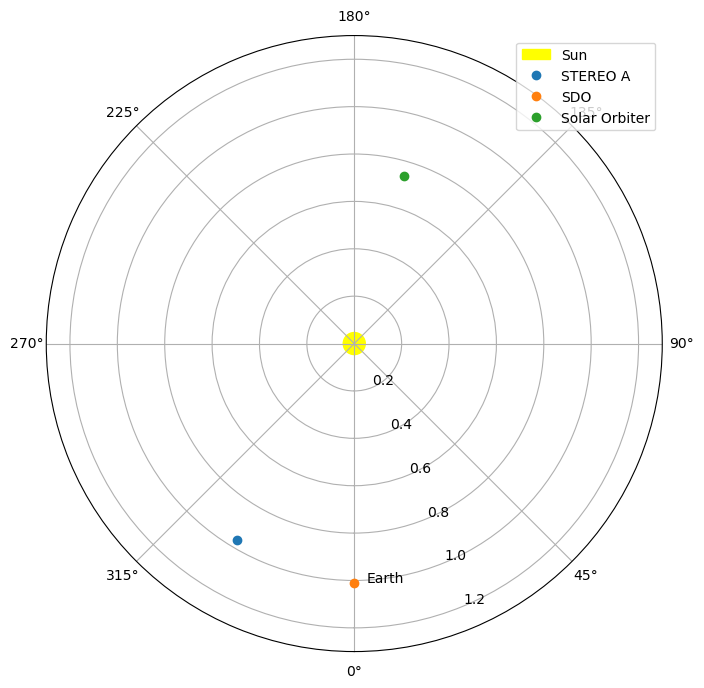

In [10]:
earth = get_body_heliographic_stonyhurst('earth', maps1[0].date)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='polar')
circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(u.AU),
                    transform=ax.transProjectionAffine + ax.transAxes, color="yellow",
                    alpha=1, label="Sun")
ax.add_artist(circle)
ax.text(earth.lon.to_value("rad")+0.05, earth.radius.to_value(u.AU), "Earth")

for this_satellite, this_coord in [(m.observatory, m.observer_coordinate) for m in maps1]:
    ax.plot(this_coord.lon.to('rad'), this_coord.radius.to(u.AU), 'o', label=this_satellite)

ax.set_theta_zero_location("S")
ax.set_rlim(0, 1.3)
ax.legend()

plt.show()

The next step is to calculate the output coordinate system for the combined
map. We select a heliographic Stonyhurst frame, and a Plate Carree (CAR)
projection, and generate a header using `sunpy.map.header_helper.make_fitswcs_header` and
then construct a World Coordinate System (WCS) object for that header.



In [41]:
shape_out = (180, 360)  # This is set deliberately low to reduce memory consumption
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                                frame="heliographic_stonyhurst",
                                                obstime=maps1[0].date),
                                       scale=[360 / shape_out[1],
                                              180 / shape_out[0]] * u.deg / u.pix,
                                       wavelength=maps1[0].wavelength,
                                       projection_code="CAR")
out_wcs = WCS(header)

Next we call the `reproject.mosaicking.reproject_and_coadd` function, which
takes a list of maps, and the desired output WCS and array shape.



In [42]:
array, footprint = reproject_and_coadd(maps1, out_wcs, shape_out,
                                       reproject_function=reproject_interp)

To display the output we construct a new map using the new array and our
generated header. We also borrow the plot settings from the AIA map.



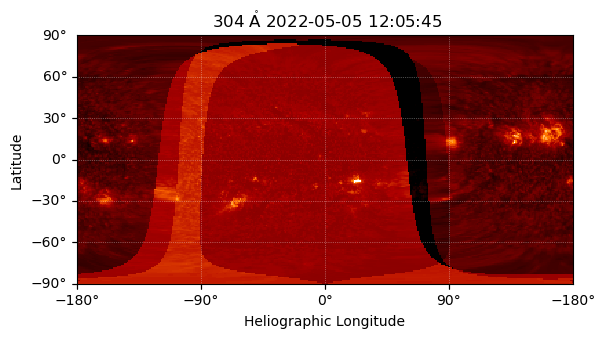

In [43]:
outmap1 = sunpy.map.Map((array, header))
outmap1.plot_settings = maps1[0].plot_settings

fig = plt.figure()
ax = fig.add_subplot(projection=outmap1)
outmap1.plot(axes=ax)

plt.show()

## Improving the Output

As you can see this leaves a little to be desired. To reduce the obvious
warping towards the points which are close to the limb in the input
images, we can define a set of weights to use when co-adding the output
arrays. To reduce this warping we want to calculate an set of weights
which highly weigh points close to the centre of the disk in the input
image.

We can achieve this by using sunpy's coordinate framework. First we
calculate all the world coordinates for all the pixels in all three
input maps.



In [44]:
coordinates1 = tuple(map(sunpy.map.all_coordinates_from_map, maps1))

To get a weighting which is high close to disk centre and low towards
the limb, we can use the Z coordinate in the heliocentric frame. This
coordinate is the distance of the sphere from the centre of the Sun
towards the observer.



In [45]:
weights1 = [coord.transform_to("heliocentric").z.value for coord in coordinates1]

These weights are good, but they are better if the ramp down is a little
smoother, and more biased to the centre. Also we can scale them to the
range 0-1, and set any off disk (NaN) regions to 0.



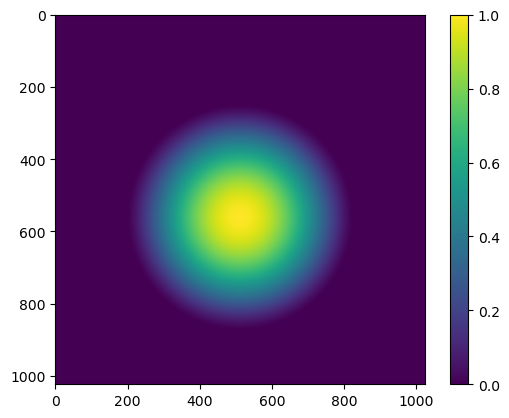

In [46]:
weights1 = [(w / np.nanmax(w)) ** 3 for w in weights1]
for w in weights1:
    w[np.isnan(w)] = 0

fig, ax = plt.subplots()
im = ax.imshow(weights1[0])
fig.colorbar(im)

plt.show()

Now we can rerun the reprojection. This time we also set
``match_background=True`` which scales the images by a single scaling
factor so they are of similar brightness. We also set
``background_reference=0`` which uses the AIA map as the reference for
the background scaling.

Here we are using the fastest but least accurate method of reprojection,
`reproject.reproject_interp`, a more accurate but slower method is
`reproject.reproject_adaptive`.



In [47]:
array1, _ = reproject_and_coadd(maps1, out_wcs, shape_out,
                               input_weights=weights1,
                               reproject_function=reproject_interp,
                               match_background=True,
                               background_reference=0)

Once again we create a new map, and this time we customize the plot a
little.



In [48]:
from reproject import reproject_interp

# Choose reference map
refmap = maps1[0]
# Reproject outmap to match refmap WCS + resolution
array_reproj1, footprint1 = reproject_interp(outmap1, refmap.wcs, shape_out=refmap.data.shape)

outmap_reproj1 = sunpy.map.Map(array_reproj1, refmap.meta)

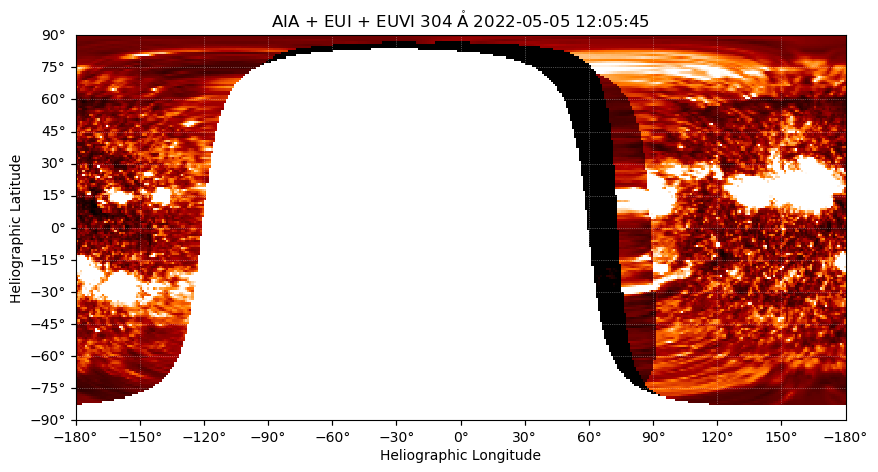

In [ ]:
# This is my edited version of the SunPy code as I wanted a more refined output
# The output seems to have corrupted somewhere as my current output does not match my one in my Paper that I achieved previously

import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch
import sunpy.map

# Create the SunPy map
outmap1 = sunpy.map.Map((array, header))
outmap1.plot_settings = maps1[0].plot_settings
outmap1.nickname = 'AIA + EUI + EUVI'

# Set up figure and axes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=outmap1)

vmin = -50
vmax = 350

# Use logarithmic scaling with vmin/vmax
norm = ImageNormalize(outmap1.data, vmin=vmin, vmax=vmax)
stretch=LogStretch()
im = outmap1.plot(axes=ax, norm=norm)

# Set coordinate labels and ticks
lon, lat = ax.coords
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=30*u.deg)
lat.set_ticks(spacing=15*u.deg)


plt.show()




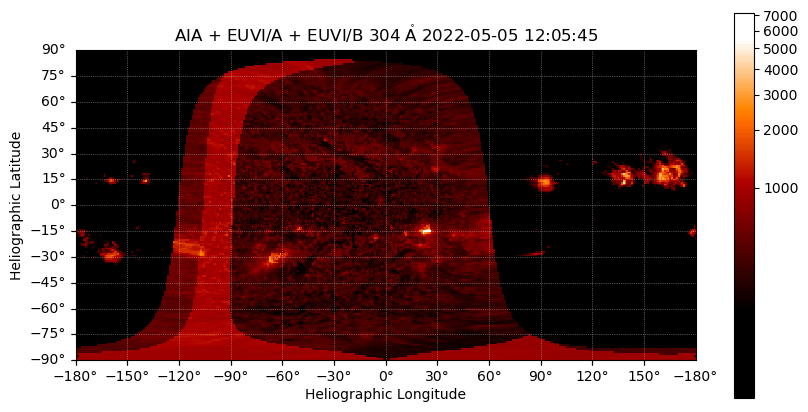

In [ ]:
#This is the default SunPy code to confirm theres an issue with my data itself

outmap1 = sunpy.map.Map((array, header))
outmap1.plot_settings = maps1[0].plot_settings
outmap1.nickname = 'AIA + EUVI/A + EUVI/B'

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=outmap1)
im = outmap1.plot(axes=ax, vmin=400)

lon, lat = ax.coords
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=30*u.deg)
lat.set_ticks(spacing=15*u.deg)

plt.colorbar(im, ax=ax)

plt.show()